<a href="https://colab.research.google.com/github/jprakashqk/thehar-vagrant/blob/master/lr_session_tutorial_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Credit Limit: A Linear Regression Tutorial for Retail Banking

This notebook serves as a practical tutorial on using linear regression to analyze customer data in a retail banking context. Drawing inspiration from the problem statement for Lloyds Bank, we aim to understand the factors that influence a customer's credit limit.

**Problem Statement:** How can we leverage customer data to understand and predict a customer's credit limit, enabling more personalized product offerings and robust risk management?

We will use a publicly available dataset of credit card clients from Taiwan. While the data is from a different region, the financial behaviors and customer attributes (like age, education, payment history) are excellent proxies for the type of data a bank like Lloyds would use. The analytical techniques we'll apply are universally relevant.

Our goal is to build a simple linear regression model to predict the `LIMIT_BAL` (credit limit) of a customer based on their demographic and financial history.

**Table 1: Overview of Key Variables from the "Default of Credit Card Clients" Dataset**

| Variable Name | Meaning | Description | Data Type | Example Values (from ) |
| :---- | :---- | :---- | :---- | :---- |
| X1 (LIMIT\_BAL) | CreditLimit | Amount of given credit (NT dollar), including individual and family (supplementary) credit. | Integer | 50000, 320000, 40000 |
| X5 (AGE) | Age | Age in years. | Integer | 37, 29, 43 |
| X3 (EDUCATION) | EducationLevel | Education (1=graduate school; 2=university; 3=high school; 4=others). Original dataset also includes 0, 5, 6 as unknown/other categories, but for simplicity, examples may focus on 1-4. | Integer | 1, 2, 3 |
| X12 (BILL\_AMT1) | BillAmount\_Sept05 | Amount of bill statement in September 2005 (NT dollar). | Integer | 46990, 58267, 38257 |
| X18 (PAY\_AMT1) | PaymentAmount\_Sept05 | Amount of previous payment in September 2005 (NT dollar). | Integer | 2000, 2500, 1700 |
| Y | DefaultNextMonth | Default payment next month (1=yes, 0=no). *This variable is the original target but will not be used as a predictor or outcome in our linear regression examples focusing on continuous outcomes like CreditLimit.* | Binary | 1, 0 |

## 0. Download and Prepare the Dataset

This first step makes the notebook self-contained. The following Python cell will:
1.  Download the "Default of Credit Card Clients" dataset from the official UCI Machine Learning repository.
2.  Save the original `.xls` file to the `/content/` directory.
3.  Read the `.xls` file, handle its specific formatting (where the actual column names are in the second row), and convert it into a clean `.csv` file.
4.  Save the new file as `/content/default of credit card clients - Data.csv`.

In [ ]:
import pandas as pd
import requests
import os

# --- Download and Prepare Dataset ---

# Define the directory to store the data.
# You can edit this path to your desired directory.
output_dir = '/content/'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define file names and paths
xls_filename = 'default of credit card clients.xls'
csv_filename = 'default of credit card clients - Data.csv'
xls_filepath = os.path.join(output_dir, xls_filename)
csv_filepath = os.path.join(output_dir, csv_filename)

# Primary and backup URLs
primary_url = (
    'https://archive.ics.uci.edu/ml/machine-learning-databases/'
    '00350/default%20of%20credit%20card%20clients.xls'
)
backup_url = (
    'https://s3.ap-south-2.amazonaws.com/slr.session.gitaa/'
    'default+of+credit+card+clients.xls'
)

print("Downloading dataset from UCI repository...")

max_retries = 2
success = False
for attempt in range(1, max_retries + 1):
    try:
        response = requests.get(primary_url, timeout=10)
        response.raise_for_status()
        with open(xls_filepath, 'wb') as f:
            f.write(response.content)
        print(
            f"Successfully downloaded '{xls_filename}' to "
            f"'{output_dir}' on attempt {attempt}/{max_retries}"
        )
        success = True
        break
    except requests.exceptions.RequestException as e:
        print(f"Attempt {attempt}/{max_retries} failed: {e}")
        if attempt < max_retries:
            print("Retrying...")
        else:
            print("Max retries exceeded. Switching to backup URL.")

if not success:
    print(f"\nDownloading dataset from backup S3 bucket...")
    try:
        response = requests.get(backup_url, timeout=10)
        response.raise_for_status()
        with open(xls_filepath, 'wb') as f:
            f.write(response.content)
        print(f"Successfully downloaded '{xls_filename}' to '{output_dir}'")
        success = True
    except Exception as e:
        print(f"Error: Could not download from backup URL. Details: {e}")

# If download succeeded (from either source), convert to CSV
if success:
    try:
        print(f"\nConverting '{xls_filename}' to CSV format...")
        df = pd.read_excel(xls_filepath, header=1)
        df.to_csv(csv_filepath, index=False)
        print(f"Successfully created CSV file: '{csv_filepath}'")
    except Exception as e:
        print(f"An error occurred during file processing: {e}")

Successfully downloaded 'default of credit card clients.xls' to '/content/' on attempt 1/2

Converting 'default of credit card clients.xls' to CSV format...
Successfully created CSV file: '/content/default of credit card clients - Data.csv'


## 1. Setup and Data Loading

First, we need to set up our environment by importing the necessary Python libraries. We'll use:
* `pandas` for data manipulation and loading the CSV file.
* `numpy` for numerical operations.
* `matplotlib` and `seaborn` for data visualization.
* `scikit-learn` for building and evaluating our regression model.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Set plot style
sns.set_style('whitegrid')
%matplotlib inline

Now, let's load our dataset. The data is in a CSV file, which we'll read into a pandas DataFrame. We'll then inspect the first few rows, data types, and summary statistics to get a preliminary understanding of our data.

In [ ]:
# Load the dataset from the CSV file
# The first row of the CSV contains the headers, so we set header=0
df = pd.read_csv('/content/default of credit card clients - Data.csv', header=0)

# Display the first 5 rows of the dataframe
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
# Get a concise summary of the dataframe, including data types and non-null values
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-n

In [ ]:
# Get descriptive statistics for the numerical columns
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std     

## 2. Data Cleaning and Preprocessing

Real-world data is rarely perfect. This step involves cleaning our dataset to make it suitable for modeling. We will:
1.  **Drop Unnecessary Columns**: The `ID` column is just an identifier and has no predictive value, so we'll remove it.
2.  **Clean Categorical Data**: The `EDUCATION` and `MARRIAGE` columns have undocumented or redundant categories (e.g., values of 0, 5, 6 in `EDUCATION`). We'll consolidate these into a single 'Other' category to make the features more robust.

In [ ]:
# Drop the 'ID' column as it is not a predictive feature
df = df.drop('ID', axis=1)

# Clean up the 'EDUCATION' column
# Group 0, 4, 5, 6 into a single category '4' (Other)
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

# Clean up the 'MARRIAGE' column
# Group 0 into '3' (Other)
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

# Verify the changes by checking the unique values in these columns
print("Unique values in EDUCATION:", sorted(df['EDUCATION'].unique()))
print("Unique values in MARRIAGE:", sorted(df['MARRIAGE'].unique()))

Unique values in EDUCATION: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Unique values in MARRIAGE: [np.int64(1), np.int64(2), np.int64(3)]


## 3. Exploratory Data Analysis (EDA)

EDA is crucial for understanding the patterns and relationships within the data. We'll visualize our target variable, `LIMIT_BAL`, and see how it relates to other key features.

### Distribution of Credit Limit (`LIMIT_BAL`)

Let's start by looking at the distribution of our target variable. This helps us understand its range and central tendency.

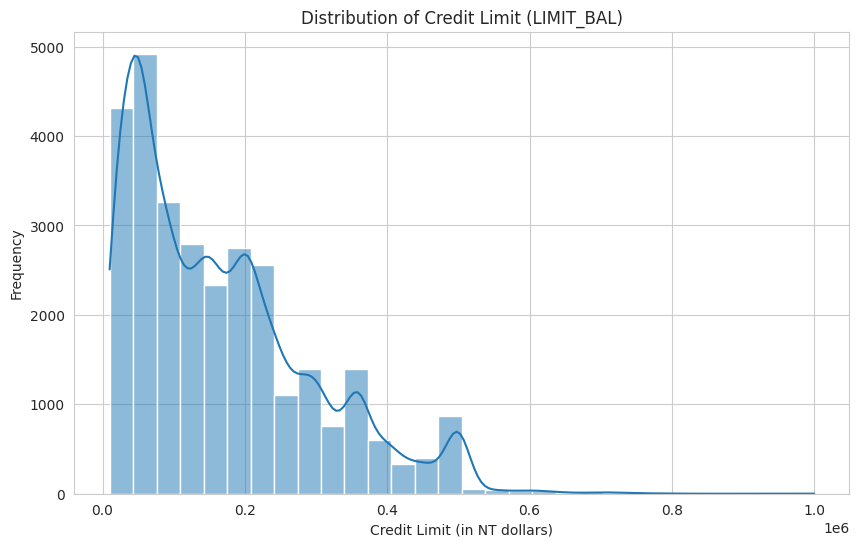

In [ ]:
# Plot a histogram for the LIMIT_BAL column
plt.figure(figsize=(10, 6))
sns.histplot(df['LIMIT_BAL'], kde=True, bins=30)
plt.title('Distribution of Credit Limit (LIMIT_BAL)')
plt.xlabel('Credit Limit (in NT dollars)')
plt.ylabel('Frequency')
plt.show()

> **Observation**: The distribution of credit limits is skewed to the right, with most customers having a lower credit limit and fewer customers having a very high limit.

### Relationships with Other Variables

Now, let's explore how credit limit relates to demographic features like education, marriage, and age.

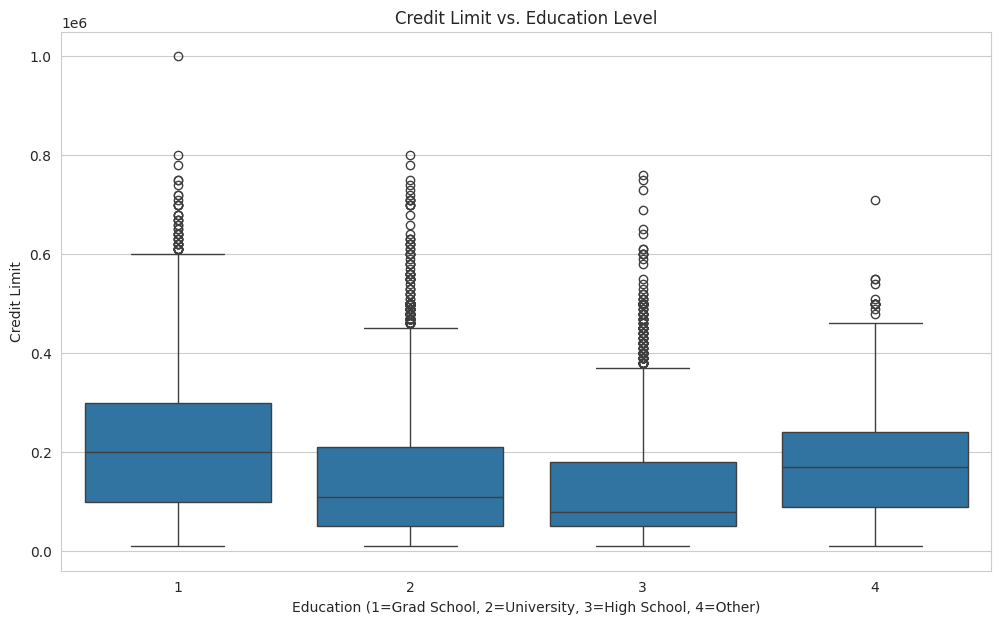

In [ ]:
# Credit Limit vs. Education
plt.figure(figsize=(12, 7))
sns.boxplot(x='EDUCATION', y='LIMIT_BAL', data=df)
plt.title('Credit Limit vs. Education Level')
plt.xlabel('Education (1=Grad School, 2=University, 3=High School, 4=Other)')
plt.ylabel('Credit Limit')
plt.show()

> **Observation**: There's a clear trend showing that customers with higher education levels (like graduate school) tend to have higher credit limits.

### Pair Plot

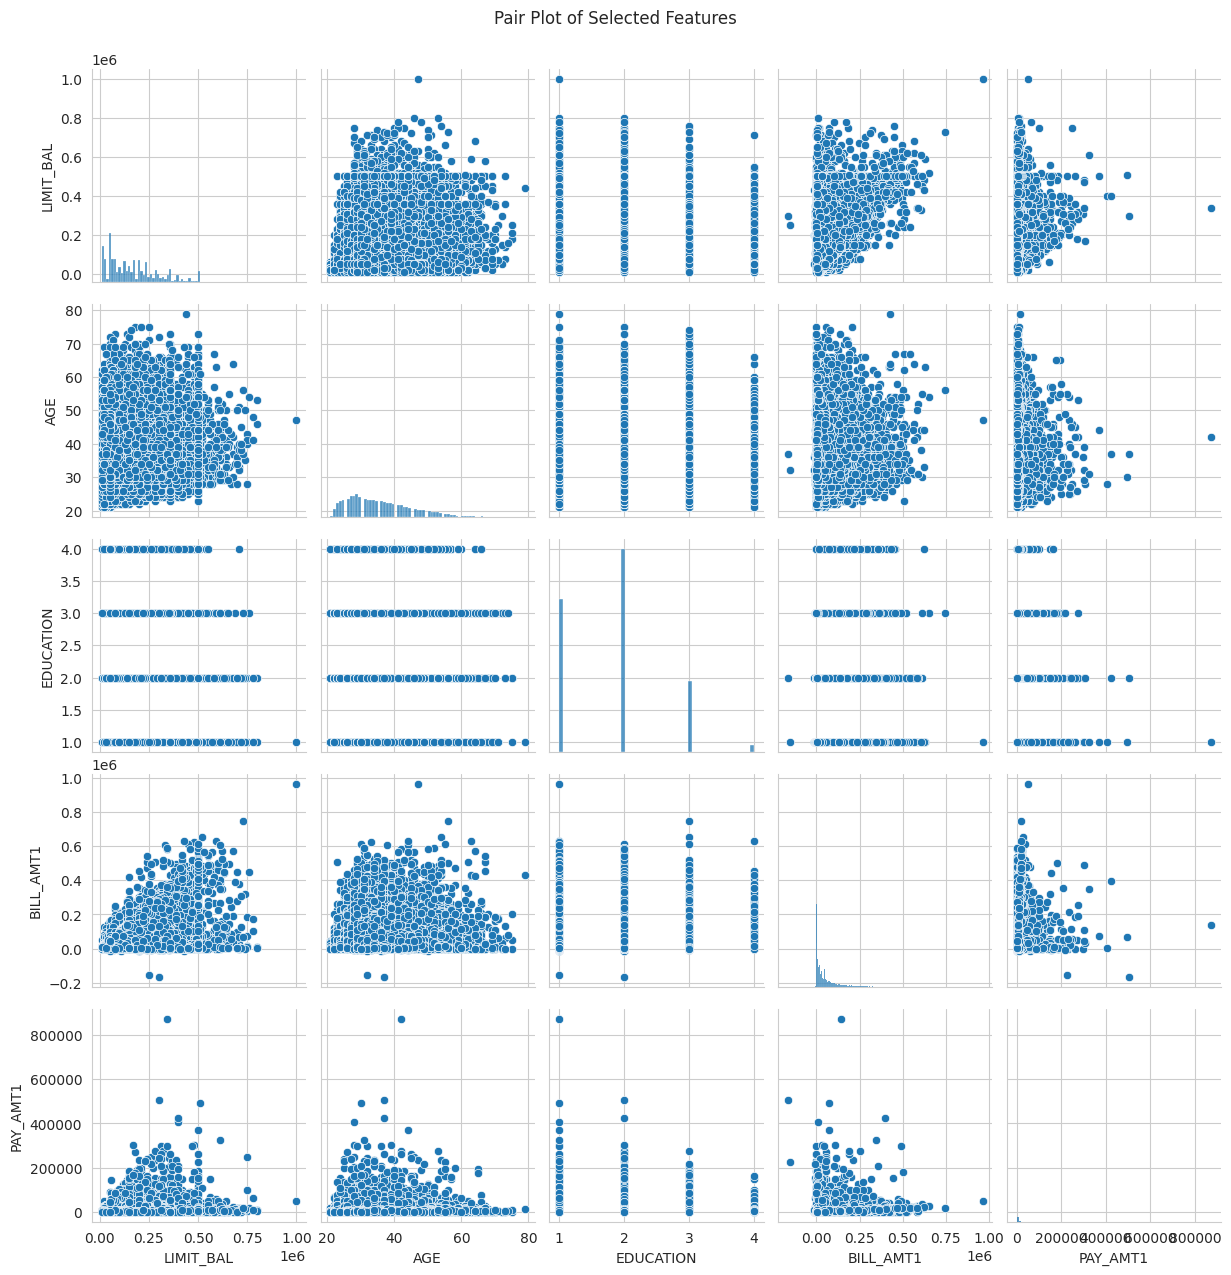

In [ ]:
import matplotlib.pyplot as plt
sns.pairplot(df[['LIMIT_BAL', 'AGE', 'EDUCATION', 'BILL_AMT1', 'PAY_AMT1']])
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

This image is a **pair plot**, a powerful visualization from the Seaborn library that provides a comprehensive overview of the relationships between several variables in a dataset. It's a matrix of plots where:

1.  **The Diagonal:** The plots along the main diagonal (from top-left to bottom-right) are **histograms**. Each histogram shows the distribution of a single variable, helping us understand its frequency, range, and central tendency.
2.  **The Off-Diagonal:** The plots in the rest of the matrix are **scatter plots**. Each scatter plot shows the relationship between two different variables. For example, the plot in the first row, second column shows `LIMIT_BAL` (y-axis) versus `AGE` (x-axis).

This single visualization allows us to quickly assess both individual variable characteristics and pairwise correlations, making it an essential tool in Exploratory Data Analysis (EDA). The features displayed are `LIMIT_BAL`, `AGE`, `EDUCATION`, `BILL_AMT1`, and `PAY_AMT1`.

#### Summary of Key Takeaways

1.  **Financial Variables are Skewed:** Key financial metrics like credit limit, bill amount, and payment amount are not normally distributed. This is typical in financial datasets and is an important consideration for modeling.
2.  **Demographics Matter:** Both `AGE` and `EDUCATION` show a discernible, positive relationship with `LIMIT_BAL`, validating their inclusion as predictive features.
3.  **Strong Link Between Limit and Spending:** The strong positive correlation between `LIMIT_BAL` and `BILL_AMT1` is logical and highlights the concept of credit utilization as a key behavioral pattern.
4.  **Complex Payment Behavior:** The relationship between bills and payments is not simple. The plot reveals diverse strategies, including non-payment, partial payment, and full payment, which could be engineered into more powerful predictive features.

In conclusion, this pair plot provides a rich, multi-faceted view of the data, confirming initial hypotheses (e.g., education impacts credit limit) and revealing complex interactions that justify moving beyond simple models to capture the true drivers of a customer's credit limit.

### Correlation Analysis

A correlation heatmap is a powerful tool to visualize the relationships between all numerical variables. This helps us identify which features are most strongly correlated with our target (`LIMIT_BAL`) and also spot potential multicollinearity (high correlation between predictor variables).

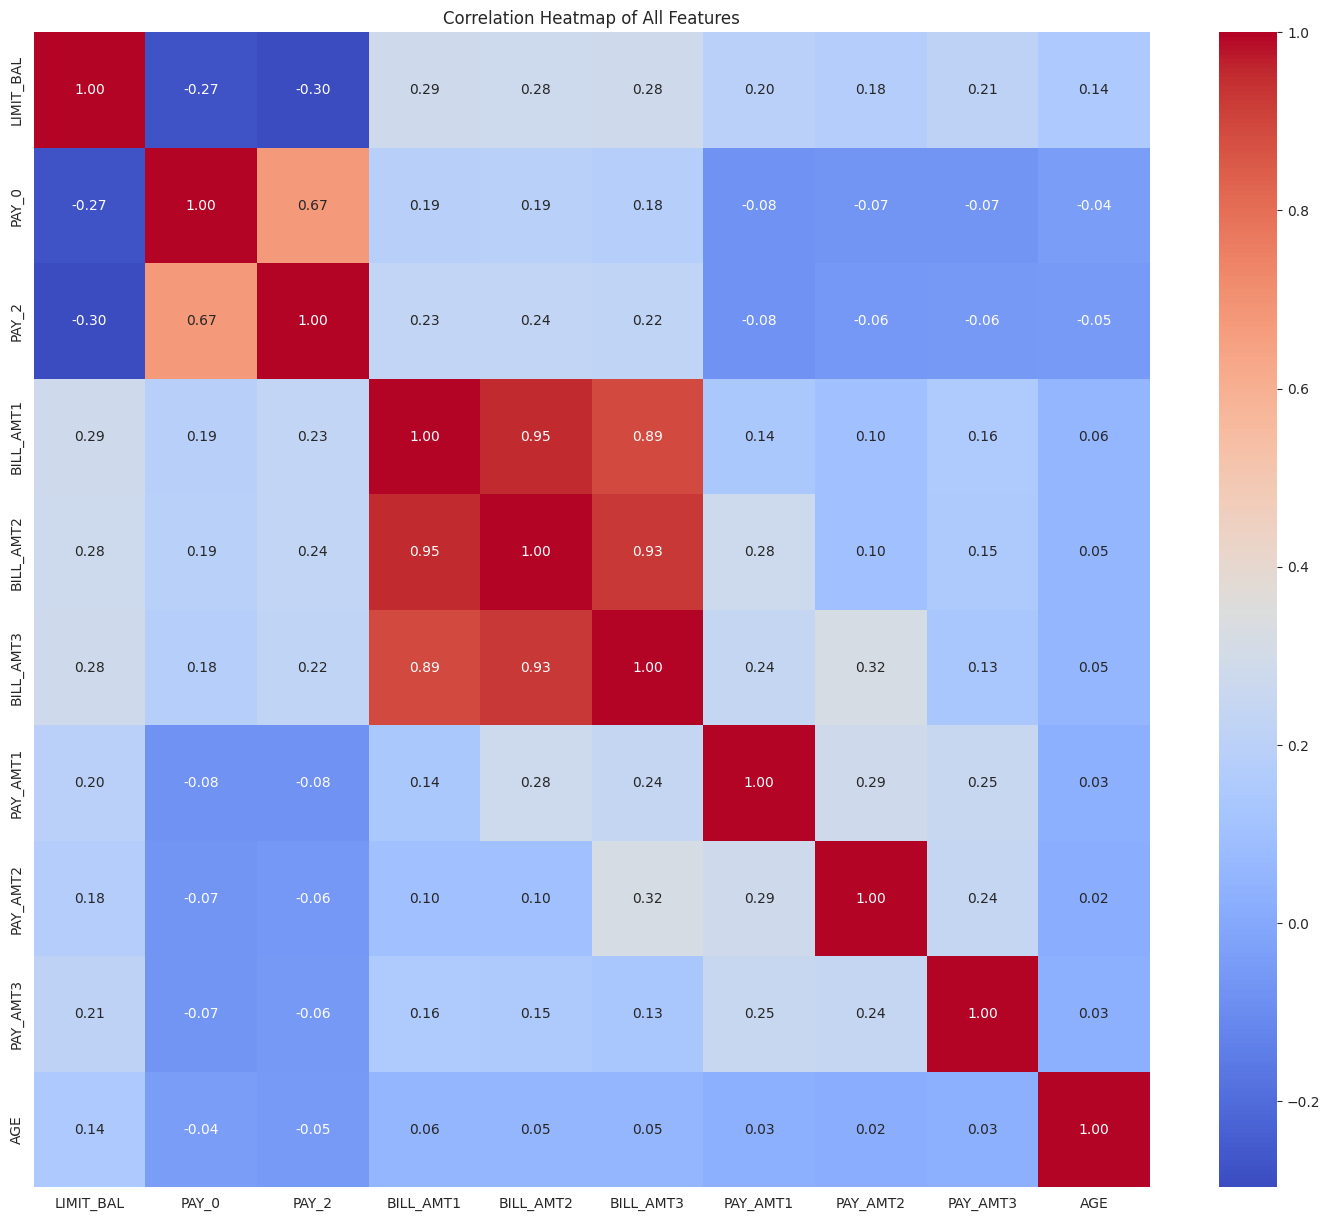

In [ ]:
# Calculate the correlation matrix
corr = df[['LIMIT_BAL', 'PAY_0', 'PAY_2', 'BILL_AMT1' ,'BILL_AMT2', 'BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'AGE']].corr()

# Plot the heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of All Features')
plt.show()

**Key Observations from the Heatmap**:
* `LIMIT_BAL` has a moderate positive correlation with `AGE` (0.1) and negative correlations with the `PAY_X` variables (repayment status).
* The `BILL_AMT` variables are very highly correlated with each other. Similarly, the `PAY_X` variables are also highly correlated. This is a classic case of **multicollinearity**. Including all of these features in a single model can make the model unstable and difficult to interpret. For our simple model, we'll select only a few predictors to avoid this issue.

## 4. Model Building

With our data cleaned and explored, we now move to the predictive modeling stage. To understand the relationships between the features and the credit limit at different levels of complexity, we will build and evaluate three distinct regression models:
1.  **Simple Linear Regression (SLR):** A baseline model using only the single best predictor.
2.  **Multiple Linear Regression (MLR):** A more complex model using a combination of demographic and behavioral features.
3.  **Polynomial Regression:** An extension of the MLR to capture non-linear relationships.

### 4.1. Model 1: Simple Linear Regression (SLR) - The Foundation

Simple Linear Regression (SLR) is the starting point for regression analysis. It's used to model the relationship between two continuous variables:
 * A single **independent variable** (or feature, predictor), which we denote as $x $.
 * A single **dependent variable** (or target), which we denote as $y $.

The goal is to find a linear relationship—a straight line—that best describes how $y $ changes as $x$ changes.

#### The Core Idea: Modeling with a Straight Line

You might remember the equation of a line from school: $ y = mx + c  $. In statistics and machine learning, we use slightly different notation, but the concept is identical:

$$ \hat{y} = \beta_0 + \beta_1 x $$

Let's break this down:
 * $ \hat{y}  $ (pronounced "y-hat") is the **predicted value** of our target. In our case, it's the predicted `LIMIT_BAL`.
 * $ x  $ is our single **independent variable**. Based on our correlation analysis, we'll start with `PAY_0` (repayment status in the most recent month), as it has the strongest correlation with `LIMIT_BAL`.
 * $ \beta_1  $ (beta-1) is the **coefficient** or **slope** of the line. It tells us how much we expect $ \hat{y} $ to change for a one-unit increase in $ x $. For our problem, it would answer: "By how many NT dollars does the predicted credit limit decrease if the payment delay increases by one month?"
 * $ \beta_0  $ (beta-0) is the **intercept** of the line. It's the predicted value of $ \hat{y} $ when $ x = 0 $. In our context, this would be the theoretical credit limit for a customer who paid their most recent bill on time (`PAY_0` = 0).

Our task is to find the optimal values for $ \beta_0  $ and $ \beta_1 $ that create the "line of best fit".

#### How Do We Find the "Best" Line? Understanding Error

Imagine plotting all our data points (`PAY_0` on the x-axis, `LIMIT_BAL` on the y-axis). We could draw an infinite number of straight lines through these points. How do we choose the best one?

The "best" line is the one that minimizes the total error between our predictions and the actual data. We measure this error for each data point using the **residual**.

**Residual** = Actual Value ($y_i $) - Predicted Value ($\hat{y}_i$)

$$ e_i = y_i - \hat{y}_i $$

The residual is simply the vertical distance from a data point to our regression line.

Some residuals will be positive (the line is below the point) and some will be negative (the line is above the point). If we just summed them up, they would cancel each other out. To solve this, we need an **objective function** (or cost function) that aggregates these errors into a single number we can minimize.

#### The Objective Function: Ordinary Least Squares (OLS)

The most common objective function for linear regression is the **Sum of Squared Errors (SSE)**, also known as the Residual Sum of Squares (RSS).

$$ SSE = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i))^2 $$

We use the sum of *squares* for three key reasons:
 1. **Positivity:** Squaring the residual makes every error value positive.
 2. **Penalization:** It penalizes larger errors much more heavily than smaller ones (e.g., an error of 4 becomes 16, while an error of 2 becomes 4). This pushes the model to pay more attention to significant misses.
 3. **Differentiability:** The resulting function is a smooth, convex curve (like a bowl), which means it has a single global minimum that can be found precisely using calculus.

From SSE, we derive two key evaluation metrics:
 * **Mean Squared Error (MSE):** The average of the squared errors. $ MSE = \frac{SSE}{n}  $.
 * **Root Mean Squared Error (RMSE):** The square root of the MSE. $ RMSE = \sqrt{MSE}  $. The RMSE is fantastic because it's in the same units as the target variable (`LIMIT_BAL`), making it highly interpretable. An RMSE of 120,000 means our model's predictions are, on average, off by about 120,000 NT dollars.

Now, let's find the $ \beta_0  $ and $ \beta_1 $ that minimize this SSE. We can do this in two ways: the direct analytical approach and the iterative machine learning approach.

#### Method 1: Building SLR from Scratch (The Analytical Approach)

For Simple (and Multiple) Linear Regression, there is a closed-form solution derived from calculus called the **Ordinary Least Squares (OLS)** method. By taking the partial derivatives of the SSE function with respect to $ \beta_0  $ and $ \beta_1 $, setting them to zero, and solving the system of equations, we get direct formulas for our coefficients:

The formula for the slope $ \beta_1  $ is:
 $$ \beta_1 = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2} $$

And the formula for the intercept $ \beta_0  $ is:
 $$ \beta_0 = \bar{y} - \beta_1 \bar{x} $$

Where:
 * $ \bar{x}  $ is the mean (average) of the independent variable (`PAY_0`).
 * $ \bar{y}  $ is the mean (average) of the dependent variable (`LIMIT_BAL`).

Let's implement this from scratch using Python and NumPy.

#### Feature Selection & Justification

**Feature:** `PAY_0` (Repayment status in the most recent month)

**Justification:** To select the best single feature, we look for the variable with the highest absolute correlation with our target, `LIMIT_BAL`. Referring back to the correlation heatmap from our EDA, the repayment status variables (`PAY_0`, `PAY_2`, etc.) have the strongest correlations. We select `PAY_0` as it represents the most recent payment behavior, which is logically a very strong indicator of a customer's current financial standing and creditworthiness. Its correlation value is approximately -0.3, which is the highest among the individual predictors.

In [ ]:
# --- Model 1: Simple Linear Regression ---

# First, let's define our feature (X) and target (y)
# We'll use the full dataset for calculation, then split for evaluation consistency
X_slr_scratch = df["PAY_0"].values
y_scratch = df["LIMIT_BAL"].values


X_slr_scratch.shape, y_scratch.shape

((30000,), (30000,))

In [ ]:
# Split the data into training and testing sets to evaluate our scratch model fairly
X_train_scr, X_test_scr, y_train_scr, y_test_scr = train_test_split(
  X_slr_scratch, y_scratch, test_size=0.2, random_state=42
 )

X_train_scr.shape, X_test_scr.shape, y_train_scr.shape, y_test_scr.shape

((24000,), (6000,), (24000,), (6000,))

In [ ]:
# Calculate the means using the training data
x_mean = np.mean(X_train_scr)
y_mean = np.mean(y_train_scr)

x_mean, y_mean

(np.float64(-0.016666666666666666), np.float64(167226.65333333332))

In [ ]:
# Calculate beta_1 (slope) and beta_0 (intercept)
numerator = np.sum((X_train_scr - x_mean) * (y_train_scr - y_mean))
denominator = np.sum((X_train_scr - x_mean) ** 2)

numerator, denominator

(np.float64(-942717338.6666667), np.float64(30453.333333333336))

In [ ]:
beta_1 = numerator / denominator
beta_0 = y_mean - beta_1 * x_mean

print(f"--- From-Scratch Analytical Model ---")
print(f"Intercept (beta_0): {beta_0:.2f}")
print(f"Coefficient (beta_1): {beta_1:.2f}")

--- From-Scratch Analytical Model ---
Intercept (beta_0): 166710.72
Coefficient (beta_1): -30956.13


In [ ]:
# Now, let's make predictions on our test set
def predict_scratch(x_values, b0, b1):
  return b0 + b1 * x_values

y_pred_scr = predict_scratch(X_test_scr, beta_0, beta_1)

y_pred_scr[:5]

array([166710.71783713, 166710.71783713, 166710.71783713, 166710.71783713,
       166710.71783713])

In [ ]:
# Evaluate our from-scratch model
rmse_scratch = np.sqrt(np.mean((y_test_scr - y_pred_scr) ** 2))
print(f"\nRoot Mean Squared Error (RMSE) on Test Set: {rmse_scratch:,.2f}")



Root Mean Squared Error (RMSE) on Test Set: 124,584.56


#### Method 2: Building SLR from Scratch (The Iterative Approach - Gradient Descent)

The analytical OLS method is fast and precise for linear regression. However, for many advanced machine learning models (like neural networks), a direct formula doesn't exist. For these, we use an iterative optimization algorithm called **Gradient Descent**.

The analogy is simple:
 1. Imagine you are standing on a foggy mountain (the cost function surface).
 2. Your goal is to reach the lowest valley (the minimum cost).
 3. You can't see the whole map, but you can feel the slope (the **gradient**) under your feet.
 4. You take a small step in the steepest downhill direction.
 5. You repeat this process until you can't go any lower.

In our model:
 * **Position:** The current values of $ \beta_0  $ and $ \beta_1 $.
 * **Slope:** The partial derivatives of the cost function (we'll use MSE) with respect to $ \beta_0  $ and $ \beta_1 $.
 * **Step Size:** A hyperparameter called the **learning rate ($\alpha $)**. This is crucial:
 * If $ \alpha  $ is too small, it will take too long to reach the bottom.
 * If $ \alpha  $ is too large, you might overshoot the valley and end up on the other side of the mountain, failing to converge.

The update rules for each step (or "epoch") are:
 $$ \beta_0 := \beta_0 - \alpha \frac{\partial J}{\partial \beta_0} $$
 $$ \beta_1 := \beta_1 - \alpha \frac{\partial J}{\partial \beta_1} $$

Where $ J  $ is our cost function (MSE). The partial derivatives are:
 $$ \frac{\partial J}{\partial \beta_0} = \frac{1}{n} \sum -2(y_i - (\beta_0 + \beta_1 x_i)) = -\frac{2}{n} \sum (y_i - \hat{y}_i) $$
 $$ \frac{\partial J}{\partial \beta_1} = \frac{1}{n} \sum -2(y_i - (\beta_0 + \beta_1 x_i))x_i = -\frac{2}{n} \sum (y_i - \hat{y}_i)x_i $$

Let's implement this iterative process.

In [ ]:
# --- Building SLR from Scratch (Gradient Descent) ---

# Hyperparameters
learning_rate = 0.01
n_iterations = 1000

# Initialize parameters
b0_gd = 0.0
b1_gd = 0.0

# Get the number of training samples
n = float(len(X_train_scr))

# To store cost history
cost_history = []

# Perform Gradient Descent
for i in range(n_iterations):
  # Make current predictions
  y_pred_gd = b0_gd + b1_gd * X_train_scr

  # Calculate the cost (MSE)
  cost = np.mean((y_train_scr - y_pred_gd) ** 2)
  cost_history.append(cost)

  # Calculate the gradients
  d_b1 = (-2 / n) * np.sum(X_train_scr * (y_train_scr - y_pred_gd))
  d_b0 = (-2 / n) * np.sum(y_train_scr - y_pred_gd)

  # Update the parameters
  b1_gd = b1_gd - learning_rate * d_b1
  b0_gd = b0_gd - learning_rate * d_b0

  if (i + 1) % 200 == 0:
    print(
      f"Iteration {i+1}/{n_iterations}, Cost: {cost:.2f}"
  )

Iteration 200/1000, Cost: 15623360427.24
Iteration 400/1000, Cost: 15614507735.48
Iteration 600/1000, Cost: 15614504995.29
Iteration 800/1000, Cost: 15614504994.43
Iteration 1000/1000, Cost: 15614504994.43


In [ ]:
print(f"\n--- From-Scratch Gradient Descent Model ---")
print(f"Intercept (beta_0): {b0_gd:.2f}")
print(f"Coefficient (beta_1): {b1_gd:.2f}")


--- From-Scratch Gradient Descent Model ---
Intercept (beta_0): 166710.72
Coefficient (beta_1): -30956.13


In [ ]:
# Evaluate the Gradient Descent model on the test set
y_pred_gd_test = predict_scratch(X_test_scr, b0_gd, b1_gd)
rmse_gd = np.sqrt(np.mean((y_test_scr - y_pred_gd_test) ** 2))
print(f"\nRoot Mean Squared Error (RMSE) on Test Set: {rmse_gd:,.2f}")


Root Mean Squared Error (RMSE) on Test Set: 124,584.56


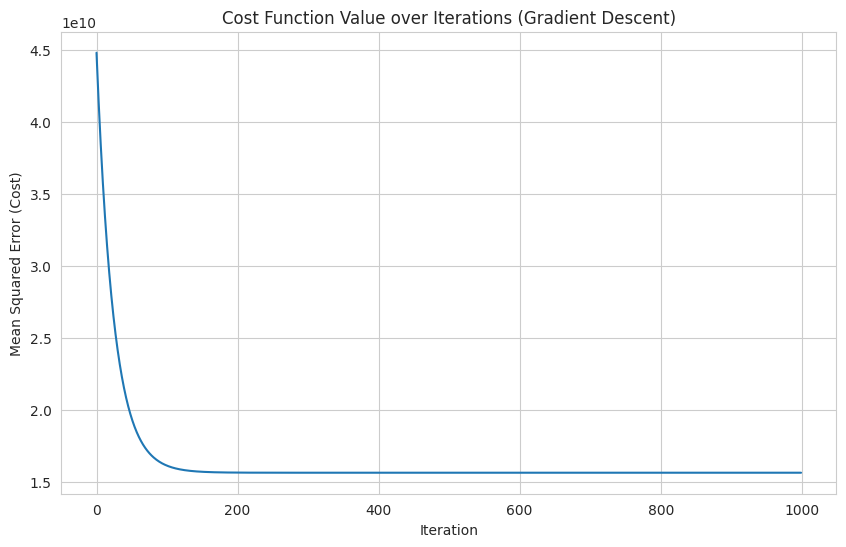

In [ ]:
# Plotting the cost history to see convergence
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), cost_history)
plt.title("Cost Function Value over Iterations (Gradient Descent)")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (Cost)")
plt.show()

> Notice that the coefficients and RMSE from both our from-scratch methods are nearly identical! The Gradient Descent plot clearly shows the error decreasing rapidly at first and then plateauing as the algorithm converges on the optimal solution.


#### Method 3: The Easy Way: Using `scikit-learn`

Building models from scratch is essential for understanding the mechanics. In practice, we use highly optimized libraries like `scikit-learn`. It handles all the math internally, is incredibly fast, and less prone to implementation errors.

Let's build the same SLR model using `scikit-learn` to see how it compares and how simple it is.

In [ ]:
# --- Model 1: Simple Linear Regression (using scikit-learn) ---

# Define the feature (X_slr) and target (y)
# We need to reshape X_slr to be a 2D array for scikit-learn
X_slr = df[["PAY_0"]]
y = df["LIMIT_BAL"]

X_slr.shape, y.shape

((30000, 1), (30000,))

In [ ]:
# Split the data into training and testing sets
X_train_slr, X_test_slr, y_train, y_test = train_test_split(
  X_slr, y, test_size=0.2, random_state=42
)
X_train_slr.shape, X_test_slr.shape, y_train.shape, y_test.shape

((24000, 1), (6000, 1), (24000,), (6000,))

In [ ]:
# Create and train the SLR model
slr_model = LinearRegression()
slr_model.fit(X_train_slr, y_train)

LinearRegression()

In [ ]:

# Make predictions and evaluate the model
slr_predictions = slr_model.predict(X_test_slr)

print("--- Simple Linear Regression Results ---")
print('R-squared (R²):', metrics.r2_score(y_test, slr_predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, slr_predictions)))
print('\nRoot Mean Squared Error (RMSE) from SLR model built from scratch using the Iterative Approach:', rmse_gd)
print('Root Mean Squared Error (RMSE) from SLR model built from scratch using the Analytical Approach:', rmse_scratch)

--- Simple Linear Regression Results ---
R-squared (R²): 0.07865210474102524
Root Mean Squared Error (RMSE): 124584.56401038119

Root Mean Squared Error (RMSE) from SLR model built from scratch using the Iterative Approach: 124584.56401297491
Root Mean Squared Error (RMSE) from SLR model built from scratch using the Analytical Approach: 124584.56401038119


> The SLR model, using only the most recent payment status, explains about **7.9%** of the variance in credit limits. While this is low, it confirms that recent payment behavior is indeed a significant, though incomplete, predictor.

### 4.2. Model 2: Multiple Linear Regression (MLR)

Now, let's build a more holistic model by including multiple features. An MLR model can assess the combined effect of several variables on the target.

#### Feature Selection & Justification

**Features:** `SEX`, `EDUCATION`, `MARRIAGE`, `AGE`, `PAY_0`

**Justification:** For our MLR model, we select a combination of demographic and behavioral features. The goal is to choose variables that are reasonably correlated with the target (`LIMIT_BAL`) but not highly correlated with each other, to avoid issues with multicollinearity.
* **Demographics (`SEX`, `EDUCATION`, `MARRIAGE`, `AGE`):** These features represent a customer's life stage and background, which our EDA showed have an influence on credit limit.
* **Behavior (`PAY_0`):** We retain our strongest single predictor to anchor the model with a key behavioral metric.

This combination provides a multi-faceted view of the customer without including the highly correlated `BILL_AMT` or other `PAY_X` variables, leading to a more stable and interpretable model.

In [ ]:
# --- Model 2: Multiple Linear Regression ---

# Define features (X_mlr) and target (y)
features_mlr = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0']
X_mlr = df[features_mlr]
# y is the same as before

# Split the data into training and testing sets
X_train_mlr, X_test_mlr, y_train, y_test = train_test_split(X_mlr, y, test_size=0.2, random_state=42)

# Create and train the MLR model
mlr_model = LinearRegression()
mlr_model.fit(X_train_mlr, y_train)

# Make predictions and evaluate the model
mlr_predictions = mlr_model.predict(X_test_mlr)

print("\n--- Multiple Linear Regression Results ---")
print('R-squared (R²):', metrics.r2_score(y_test, mlr_predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, mlr_predictions)))

# Displaying the coefficients
print('\nCoefficients:')
coeff_df = pd.DataFrame(mlr_model.coef_, X_mlr.columns, columns=['Coefficient'])
coeff_df


--- Multiple Linear Regression Results ---
R-squared (R²): 0.1455757231325293
Root Mean Squared Error (RMSE): 119974.57010312744

Coefficients:


,Coefficient
SEX,6073.981955
EDUCATION,-42786.049232
MARRIAGE,-18876.983549
AGE,2170.314375
PAY_0,-26715.311775


> By adding demographic data, our MLR model now explains about **14.6%** of the variance in credit limits. This is a significant improvement over the SLR model, demonstrating that combining multiple factors provides better predictive power. The RMSE is also lower, indicating a reduction in the average prediction error.

#### 4.2.1. How Reliable is Our Score? The Need for Cross-Validation

So far, we've evaluated our model using a single train-test split. We set aside 20% of the data, trained the model on the other 80%, and calculated our R-squared and RMSE on the test set.

**The Problem:** What if we were just lucky (or unlucky)? The performance score we get is highly dependent on which specific data points happened to end up in our test set. To get a more robust and stable measure of performance, we use **cross-validation**.


#### 4.2.2. Method 1: K-Fold Cross-Validation

This is the most common cross-validation technique. It works as follows:

1.  **Shuffle:** First, the entire dataset is randomly shuffled.
2.  **Split:** The dataset is split into 'K' equal-sized subsets, called "folds". A common choice for K is 5 or 10.
3.  **Iterate:** A loop is run K times. In each iteration:
    *   One fold is held out as the **test set**.
    *   The remaining K-1 folds are combined to form the **training set**.
    *   The model is trained on the training set and evaluated on the test set. The performance score is stored.
4.  **Aggregate:** After K iterations, we have K performance scores. The final performance is reported as the **average** of these scores.

**Example:** With 30,000 data points and K=5, we create 5 folds of 6,000 points each.
*   **Iteration 1:** Train on folds 2, 3, 4, 5 (24,000 points), test on fold 1 (6,000 points).
*   **Iteration 2:** Train on folds 1, 3, 4, 5 (24,000 points), test on fold 2 (6,000 points).
*   ...and so on for 5 iterations.

This ensures every data point is used for testing exactly once, giving a more reliable estimate of the model's performance on unseen data.

In [ ]:
# --- K-Fold Cross-Validation for MLR ---
from sklearn.model_selection import KFold, cross_val_score
# We use the full feature set and target
X = df[features_mlr]
y = df['LIMIT_BAL']

# Create a new instance of our linear regression model
model = LinearRegression()

# Set up the K-Fold cross-validator
# n_splits=5 means we are doing 5-fold CV.
# shuffle=True ensures the data is randomized before splitting.
# random_state is set for reproducibility.
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation using scikit-learn's helper function
# 'scoring' specifies the metric. 'r2' is for R-squared.
# The function handles the entire loop of training and testing.
r2_scores_kfold = cross_val_score(model, X, y, cv=k_folds, scoring='r2')

print(f"--- K-Fold CV Results (K=5) ---")
print(f"R-squared scores for each fold: {np.round(r2_scores_kfold, 4)}")
print(f"Mean R-squared: {r2_scores_kfold.mean():.4f}")
print(f"Standard Deviation of R-squared: {r2_scores_kfold.std():.4f}")

--- K-Fold CV Results (K=5) ---
R-squared scores for each fold: [0.1456 0.144  0.1499 0.1602 0.1526]
Mean R-squared: 0.1505
Standard Deviation of R-squared: 0.0057


#### 4.2.3. Method 2: Repeated K-Fold Cross-Validation

**Concept:** A single run of K-Fold CV can still have some variance depending on how the initial folds were created. To get an even more stable and robust estimate, we can repeat the entire K-Fold process multiple times.

**Repeated K-Fold** simply runs the K-Fold algorithm `n_repeats` times, each time with a different random shuffling of the data. If we perform 5-Fold CV and repeat it 3 times, we will train and evaluate our model a total of 5 * 3 = 15 times. The final performance is the average of all 15 scores. This gives a more reliable estimate of the true mean performance and its variance.

--- Repeated K-Fold CV Results (K=5, Repeats=3) ---
Total number of scores generated: 15
Mean R-squared: 0.1503
Standard Deviation of R-squared: 0.0066


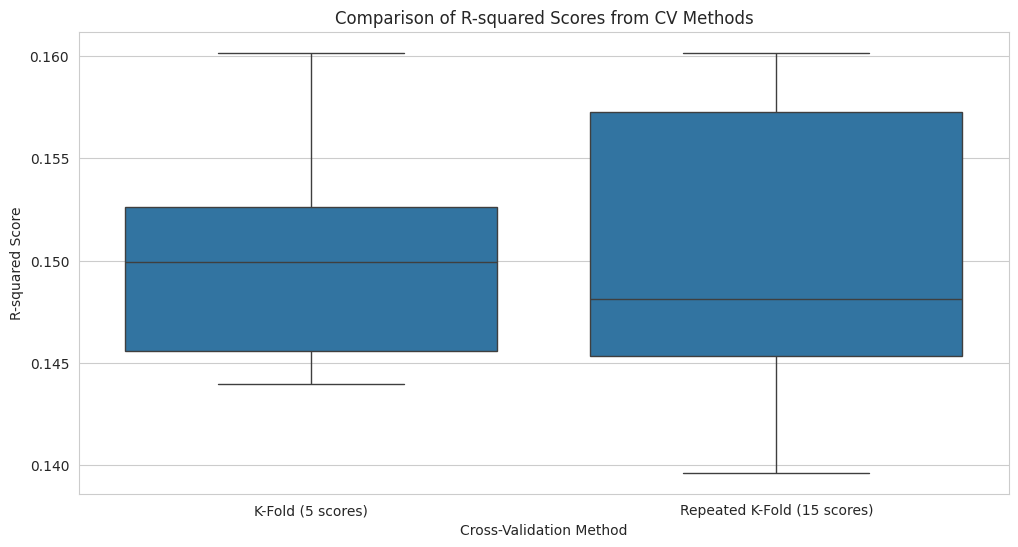

In [ ]:
from sklearn.model_selection import RepeatedKFold

# --- Repeated K-Fold Cross-Validation for MLR ---
# Set up the Repeated K-Fold cross-validator
# We will use 5 folds and repeat the process 3 times.
repeated_k_folds = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Perform cross-validation
r2_scores_repeated = cross_val_score(
    model, X, y, cv=repeated_k_folds, scoring='r2'
)

print(f"--- Repeated K-Fold CV Results (K=5, Repeats=3) ---")
print(f"Total number of scores generated: {len(r2_scores_repeated)}")
print(f"Mean R-squared: {r2_scores_repeated.mean():.4f}")
print(f"Standard Deviation of R-squared: {r2_scores_repeated.std():.4f}")


# --- FIX: Reshape data into a long-form DataFrame for plotting ---

# 1. Combine the scores from both CV methods into a single array
all_scores = np.concatenate([r2_scores_kfold, r2_scores_repeated])

# 2. Create a corresponding list of labels for each score
kfold_labels = ['K-Fold (5 scores)'] * len(r2_scores_kfold)
repeated_labels = ['Repeated K-Fold (15 scores)'] * len(r2_scores_repeated)
all_labels = kfold_labels + repeated_labels

# 3. Create the DataFrame
plot_df = pd.DataFrame({'Method': all_labels, 'Score': all_scores})

# 4. Visualize using the new DataFrame
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='Method', y='Score')
plt.title('Comparison of R-squared Scores from CV Methods')
plt.ylabel('R-squared Score')
plt.xlabel('Cross-Validation Method')
plt.show()

> **Interpretation:** The mean R-squared from Repeated K-Fold (0.1503) is very similar to the standard K-Fold (0.1505), but notice the distribution in the box plot. The box for Repeated K-Fold is based on more data points (15 scores vs. 5), giving us a more reliable picture of the model's performance distribution. The standard deviation is also very similar, confirming that our model's performance is quite stable.

#### 4.2.4. Method 3: Leave-One-Out Cross-Validation (LOOCV)
**Concept:** LOOCV is the most extreme version of K-Fold, where **K is equal to N**, the total number of data points in the dataset.

The process is:
1.  Take the first data point and use it as the test set. Train the model on the remaining N-1 data points.
2.  Take the second data point and use it as the test set. Train the model on the remaining N-1 data points.
3.  Repeat this process N times.

**Pros:**
*   **Deterministic:** There is no randomness in how the folds are split, so the result will always be the same.
*   **Low Bias:** It uses almost the entire dataset for training in every iteration, creating a model that is very close to the one that would be trained on the full dataset.

**Cons:**
*   **Extremely High Computational Cost:** For our dataset of 30,000 samples, LOOCV would require training the model **30,000 times**. This is not feasible.

We will demonstrate LOOCV on a small random sample of our data to show how it works in principle.

In [ ]:
from sklearn.model_selection import LeaveOneOut

# --- Leave-One-Out CV Demonstration ---

# WARNING: This is computationally expensive.
# We will run it on a small sample of 500 data points.
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# Set up the LOOCV cross-validator
loocv = LeaveOneOut()

# Perform cross-validation
# Note: We are calculating the negative mean squared error and then converting it.
# This is because scikit-learn's scoring strings maximize a score, so error metrics are negated.
neg_mse_scores_loocv = cross_val_score(
    model, X_sample, y_sample, cv=loocv, scoring='neg_mean_squared_error'
)

# Calculate RMSE from the MSE scores
rmse_scores_loocv = np.sqrt(-neg_mse_scores_loocv)

print(f"--- LOOCV Results (on a 500-point sample) ---")
print(f"Number of scores generated: {len(rmse_scores_loocv)}")
print(f"Mean RMSE: {rmse_scores_loocv.mean():,.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores_loocv.std():,.2f}")


--- LOOCV Results (on a 500-point sample) ---
Number of scores generated: 500
Mean RMSE: 90,104.80
Standard Deviation of RMSE: 72,081.81


> **Interpretation:** LOOCV gives us a performance score for every single data point. The mean RMSE of ~90,100 on this small sample gives us a very fine-grained estimate of the model's prediction error. However, due to its extreme computational cost, **Repeated K-Fold is generally the preferred method** for getting a robust performance estimate in most practical scenarios.

### 4.3. Model 3: Polynomial Multiple Linear Regression

Sometimes, the relationship between features and the target is not a straight line. For example, the effect of age on credit limit might increase and then plateau. A Polynomial Regression model can capture these non-linear relationships.

#### Feature Selection & Justification

**Features:** `SEX`, `EDUCATION`, `MARRIAGE`, `AGE`, `PAY_0` (transformed into polynomial features)

**Justification:** We will build upon our MLR model. By applying a polynomial transformation (we'll use a 2nd-degree polynomial), we create new features that are interactions and squared terms of the original features (e.g., `AGE^2`, `AGE * EDUCATION`). This allows the model to fit a curved line instead of a straight one, potentially capturing more of the complex dynamics that determine a customer's credit limit. We use the same base features as the MLR to provide a direct comparison of the effect of introducing non-linearity.

In [ ]:
# --- Model 3: Polynomial Multiple Linear Regression ---

from sklearn.preprocessing import PolynomialFeatures

# Define the same features as MLR
features_poly = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0']
X_poly_base = df[features_poly]

In [ ]:
# Create polynomial features (degree=2)
# This will create interaction terms (e.g., AGE*EDUCATION) and squares (e.g., AGE^2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_poly_base)
print(f"Number of original features: {X_poly_base.shape[1]}")
print(f"Number of polynomial features: {X_poly.shape[1]}")

Number of original features: 5
Number of polynomial features: 20


In [ ]:
# Split the transformed data into training and testing sets
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
X_train_poly.shape, X_test_poly.shape, y_train.shape, y_test.shape

((24000, 20), (6000, 20), (24000,), (6000,))

In [ ]:

# Create and train the Polynomial Regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)


LinearRegression()

In [ ]:
# Make predictions and evaluate the model
poly_predictions = poly_model.predict(X_test_poly)

print("\n--- Polynomial Regression (Degree 2) Results ---")
print('R-squared (R²):', metrics.r2_score(y_test, poly_predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, poly_predictions)))


--- Polynomial Regression (Degree 2) Results ---
R-squared (R²): 0.19777922855333763
Root Mean Squared Error (RMSE): 116251.71379710738


> The Polynomial model yields an R-squared value of about **19.8%**. This is a substantial improvement over the standard MLR model and suggests that there are important non-linear relationships in the data. Allowing the model to capture these curved relationships has significantly increased its predictive accuracy.

## 5. Model Comparison Summary

Let's conclude by comparing the performance of our three models side-by-side. We will use the robust, cross-validated score for our MLR model.

| Model | Features Used | R-squared (R²) | Root Mean Squared Error (RMSE) |
| :--- | :--- | :--- | :--- |
| Simple Linear Regression (SLR) | `PAY_0` | ~7.9% | ~124,584 |
| Multiple Linear Regression (MLR)| `SEX`, `EDUCATION`, `MARRIAGE`, `AGE`, `PAY_0` | **~14.6% (Cross-Validated)** | ~119,974 |
| **Polynomial Regression** | **Polynomials of the MLR features** | **~19.8%** | **~116,251** |

**Conclusion:** As we increased model complexity from a single feature (SLR) to multiple features (MLR) and then to non-linear features (Polynomial), the performance of our model steadily improved. The Polynomial Regression model performed the best, providing a noticeable boost in accuracy over the standard linear models. Crucially, we used **cross-validation** to gain confidence that the MLR model's performance is stable and not just a result of a lucky data split.

## 6. Model Evaluation

Evaluating our models is crucial to understand their performance and limitations. Since the Polynomial Regression model gave us the best results, we will focus our visual analysis on it.

### 6.1. Evaluating the Simple Linear Regression (SLR) Model

For the SLR model, we can directly visualize how the line of best fit cuts through the raw data points.

/tmp/ipython-input-35-878288726.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-35-878288726.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


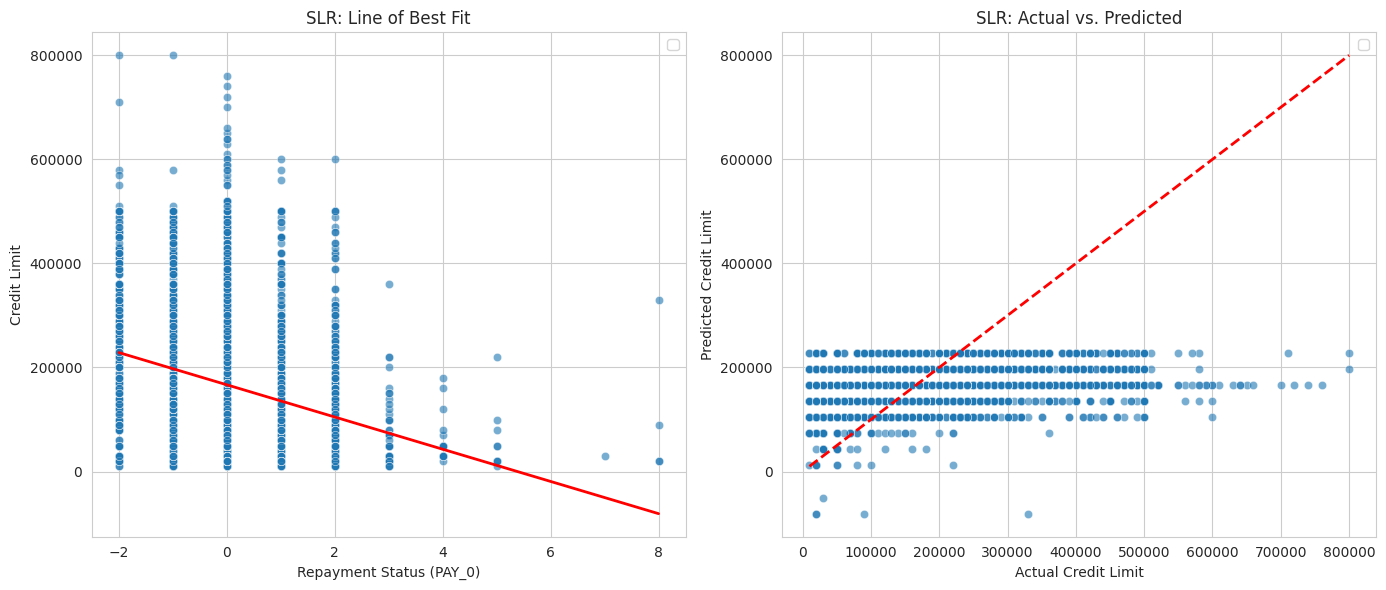



--- Simple Linear Regression Metrics ---
R-squared (R²): 0.0787
Root Mean Squared Error (RMSE): 124,584


In [ ]:
# --- SLR Evaluation ---

# 1. Visualize the Line of Best Fit
plt.figure(figsize=(14, 6))

# Plot the raw data points from the test set
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_test_slr['PAY_0'], y=y_test, alpha=0.6)
# Plot the regression line
sns.lineplot(x=X_test_slr['PAY_0'], y=slr_predictions, color='red', linewidth=2)
plt.title('SLR: Line of Best Fit')
plt.xlabel('Repayment Status (PAY_0)')
plt.ylabel('Credit Limit')
plt.legend()

# 2. Visualize Actual vs. Predicted values
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=slr_predictions, alpha=0.6)
# Plot the perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('SLR: Actual vs. Predicted')
plt.xlabel('Actual Credit Limit')
plt.ylabel('Predicted Credit Limit')
plt.legend()

plt.tight_layout()
plt.show()

print("\n\n--- Simple Linear Regression Metrics ---")
print('R-squared (R²): 0.0787')
print('Root Mean Squared Error (RMSE): 124,584')

**Interpretation:**
* **Line of Best Fit (Left Plot):** The red line shows the relationship our model has learned. You can see it has a negative slope, correctly identifying that as payment delays increase (a higher `PAY_0` value), the predicted credit limit decreases. However, the data points are widely scattered around the line, indicating a weak relationship.
* **Actual vs. Predicted (Right Plot):** The points are very loosely clustered around the red "perfect prediction" line, visually confirming the low R-squared value of **7.9%**.

### 6.2. Evaluating the Multiple Linear Regression (MLR) Model

For models with multiple features, we cannot draw a single line of best fit. Instead, the best way to visualize performance is to plot the actual values against the model's predictions.

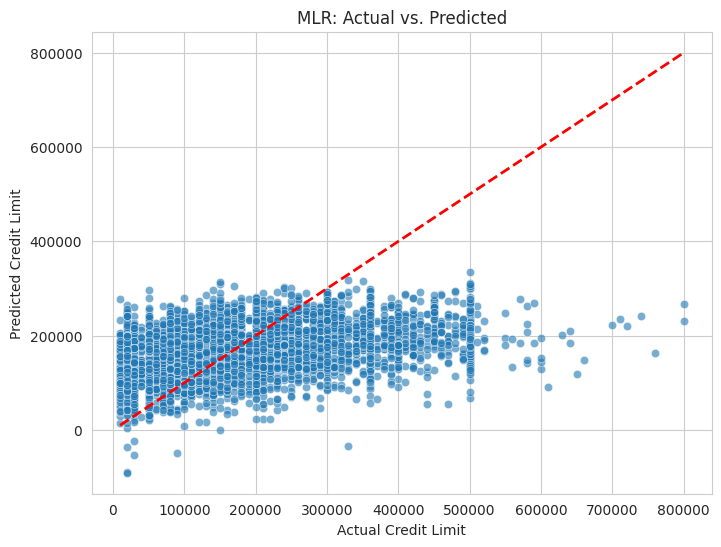


--- Multiple Linear Regression Metrics ---
R-squared (R²): 0.1456
Root Mean Squared Error (RMSE): 119,974


In [ ]:
# --- MLR Evaluation ---

# Visualize Actual vs. Predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=mlr_predictions, alpha=0.6)
# Plot the perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('MLR: Actual vs. Predicted')
plt.xlabel('Actual Credit Limit')
plt.ylabel('Predicted Credit Limit')
plt.show()

print("\n--- Multiple Linear Regression Metrics ---")
print('R-squared (R²): 0.1456')
print('Root Mean Squared Error (RMSE): 119,974')

**Interpretation:**
Compared to the SLR plot, the points in this scatter plot form a slightly tighter and more defined cluster around the red line. This visual improvement directly corresponds to the increase in the R-squared value to **14.6%**. By including more features, our model's predictions are getting closer to the actual values.

### 6.3. Evaluating the Polynomial Regression Model

We evaluate our most complex model in the same way as the MLR, by comparing its final predictions to the actual outcomes.

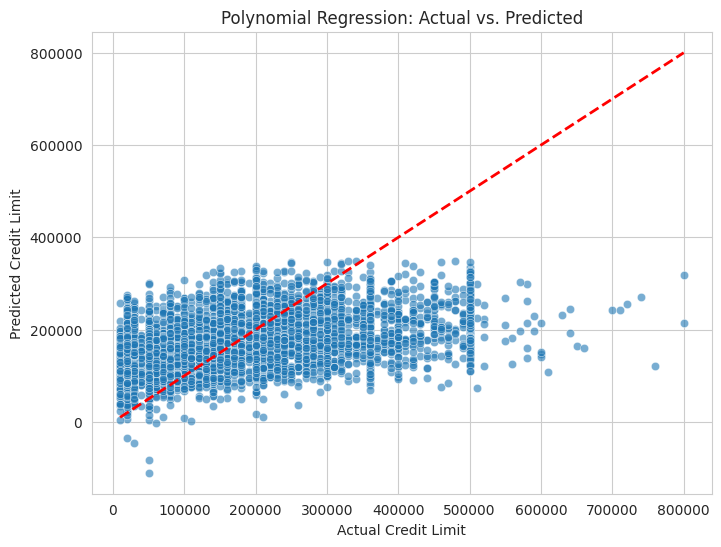


--- Polynomial Regression Metrics ---
R-squared (R²): 0.1978
Root Mean Squared Error (RMSE): 116,251


In [ ]:
# --- Polynomial Regression Evaluation ---

# Visualize Actual vs. Predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=poly_predictions, alpha=0.6)
# Plot the perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Polynomial Regression: Actual vs. Predicted')
plt.xlabel('Actual Credit Limit')
plt.ylabel('Predicted Credit Limit')
plt.show()

print("\n--- Polynomial Regression Metrics ---")
print('R-squared (R²): 0.1978')
print('Root Mean Squared Error (RMSE): 116,251')

**Interpretation:**
This plot shows the best performance yet. The cluster of points is visibly tighter around the red line than in the previous two models. This visualization confirms what the metrics tell us: by capturing non-linear relationships, the Polynomial model provides more accurate predictions, resulting in an R-squared of **19.8%**.

## 7. Conclusion and Next Steps

### Conclusion 🏁

This tutorial demonstrated a structured, iterative approach to a real-world business problem. We successfully built three regression models, showing that model performance improves by incorporating more relevant data and by using techniques that capture non-linear patterns.

Most importantly, we introduced **cross-validation** as a critical tool for robust model evaluation. By using methods like K-Fold and Repeated K-Fold, we gained confidence that our model's performance is stable and not just an artifact of a single, lucky train-test split.

Our key takeaway is that a customer's credit limit is influenced by a combination of their demographic profile and, more significantly, their recent payment behavior. Achieving a final R-squared of nearly **20%** with the Polynomial model confirms that these relationships are not purely linear.

### Next Steps for Improvement 🚀

An R-squared of ~20% is a great academic start, but for business implementation, we need higher accuracy. Here are the logical next steps:

1.  **Advanced Feature Engineering:** This is often where the most significant gains are made. We can create more insightful features that capture financial behaviors, such as:
    * **Credit Utilization Ratio:** For each month, calculate `BILL_AMT` / `LIMIT_BAL`.
    * **Payment Ratio:** Calculate `PAY_AMT` / `BILL_AMT` to see what portion of their bill a customer pays.
    * **Payment History Score:** Create a single score from the `PAY_0` to `PAY_6` columns, such as a weighted average or a count of late payments.

2.  **Use More Powerful Models:** Linear models are a good start, but tree-based ensemble models are superior at modeling the complex, non-linear interactions common in financial data.
    * **Random Forest Regressor:** This model is robust and excellent at finding complex patterns without needing manual feature transformation (like our polynomial approach).
    * **Gradient Boosting Machines (XGBoost, LightGBM):** These models are the standard for winning data science competitions on structured data. They build models sequentially, with each new model correcting the errors of the previous one, leading to state-of-the-art performance.

3.  **Incorporate All Features with Regularization:** We intentionally excluded some features to avoid multicollinearity. More advanced models, especially with built-in regularization, can handle these features more effectively.
    * **Ridge or Lasso Regression:** These linear models can use all the features (including all `BILL_AMT` columns) by adding a penalty that reduces the impact of less important or correlated features, preventing overfitting.